In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from datetime import datetime, timedelta

In [ ]:
DATABASE_FILE_PATH = '/content/drive/MyDrive/crypto_data.db'
MODEL_SAVE_PATH = '/content/drive/MyDrive/linear_regression_model.joblib' # Where to save the model
COIN_TO_PREDICT = 'BTCUSDT'

#### 1. DATA PREPARATION

In [ ]:
def load_and_prepare_data(db_path, symbol):
    print("--- 1. Loading and Preparing Data ---")
    conn = sqlite3.connect(db_path)
    query = f"SELECT Date, Close FROM crypto_prices WHERE Symbol = '{symbol}' ORDER BY Date ASC"
    df = pd.read_sql_query(query, conn, parse_dates=['Date'], index_col='Date')
    conn.close()

    if df.empty:
        print(f"No data found for {symbol}. Exiting.")
        return None

    df['Return'] = df['Close'].pct_change() * 100
    for i in range(1, 6):
        df[f'Lag_{i}'] = df['Return'].shift(i)

    df['Target_Return'] = df['Return'].shift(-1)
    df.dropna(inplace=True)

    print(f"Data prepared for {symbol} with {len(df)} samples.")
    return df

#### 2. MODEL TRAINING & SAVING

In [ ]:
def train_and_save_model(df, model_path):
    print("\n--- 2. Training and Saving the Model ---")

    features = [f'Lag_{i}' for i in range(1, 6)]
    X = df[features]
    y = df['Target_Return']

    split_point = int(len(X) * 0.8)
    X_train, X_test = X[:split_point], X[split_point:]
    y_train, y_test = y[:split_point], y[split_point:]

    model = LinearRegression()
    model.fit(X_train, y_train)
    print("Model training complete.")

    print("\n--- Model Parameters (What the model learned) ---")
    print("Linear Regression doesn't use 'epochs' like neural networks. It solves for its parameters mathematically in one step.")
    print("The key learned parameters are the coefficients (weights) for each feature and the intercept.")
    for feature, coef in zip(features, model.coef_):
        print(f"  - Coefficient for {feature}: {coef:.4f}")
    print(f"  - Model Intercept: {model.intercept_:.4f}")

    joblib.dump(model, model_path)
    print(f"\n✅ Model successfully saved to: {model_path}")

    return model, X_train, X_test, y_train, y_test

#### 3. PREDICTION & VISUALIZATION

In [ ]:
def make_predictions_and_plot(model, df, X_test, y_test):
    print("\n--- 3. Making Predictions and Visualizing Performance ---")

    predicted_returns = model.predict(X_test)

    results_df = pd.DataFrame(index=y_test.index)
    results_df['Actual_Return'] = y_test
    results_df['Predicted_Return'] = predicted_returns

    last_known_prices = df['Close'].shift(1)[y_test.index]
    results_df['Predicted_Price'] = last_known_prices * (1 + results_df['Predicted_Return'] / 100)
    results_df['Actual_Price'] = df['Close'][y_test.index]

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(15, 8))

    plt.plot(df.index, df['Close'], label='Historical Price', color='gray', alpha=0.6)

    plt.plot(results_df.index, results_df['Actual_Price'], label='Actual Price (Test Set)', color='blue', linewidth=2)

    plt.plot(results_df.index, results_df['Predicted_Price'], label='Predicted Price (Test Set)', color='red', linestyle='--')

    plt.title(f'Historical vs. Predicted Prices for {COIN_TO_PREDICT}', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

#### 4. LOAD MODEL & PREDICT FOR A SPECIFIC DATE

In [ ]:
def load_and_predict_future(df, model_path, target_date_str):
    print(f"\n--- 4. Loading Saved Model to Predict for {target_date_str} ---")

    try:
        loaded_model = joblib.load(model_path)
        print("Model loaded successfully from drive.")
    except FileNotFoundError:
        print(f"ERROR: Model file not found at {model_path}. Please train and save the model first.")
        return

    target_date = pd.to_datetime(target_date_str)
    last_known_date = target_date - timedelta(days=1)

    features_for_prediction = df['Return'].loc[:last_known_date].tail(5).values

    if len(features_for_prediction) < 5:
        print("  > ERROR: Not enough recent data to make a prediction.")
        return

    predicted_return = loaded_model.predict([features_for_prediction])[0]

    last_known_price = df['Close'].loc[:last_known_date].iloc[-1]
    predicted_price = last_known_price * (1 + predicted_return / 100)

    print("\n--- Single Day Prediction ---")
    print(f"PREDICTED PRICE for {target_date.date()}: ${predicted_price:,.2f}")

MAIN EXECUTION BLOCK

--- 1. Loading and Preparing Data ---
Data prepared for BTCUSDT with 1493 samples.

--- 2. Training and Saving the Model ---
Model training complete.

--- Model Parameters (What the model learned) ---
Linear Regression doesn't use 'epochs' like neural networks. It solves for its parameters mathematically in one step.
The key learned parameters are the coefficients (weights) for each feature and the intercept.
  - Coefficient for Lag_1: 0.0125
  - Coefficient for Lag_2: 0.0057
  - Coefficient for Lag_3: 0.0135
  - Coefficient for Lag_4: 0.0249
  - Coefficient for Lag_5: -0.0300
  - Model Intercept: 0.1049

✅ Model successfully saved to: /content/drive/MyDrive/linear_regression_model.joblib

--- 3. Making Predictions and Visualizing Performance ---


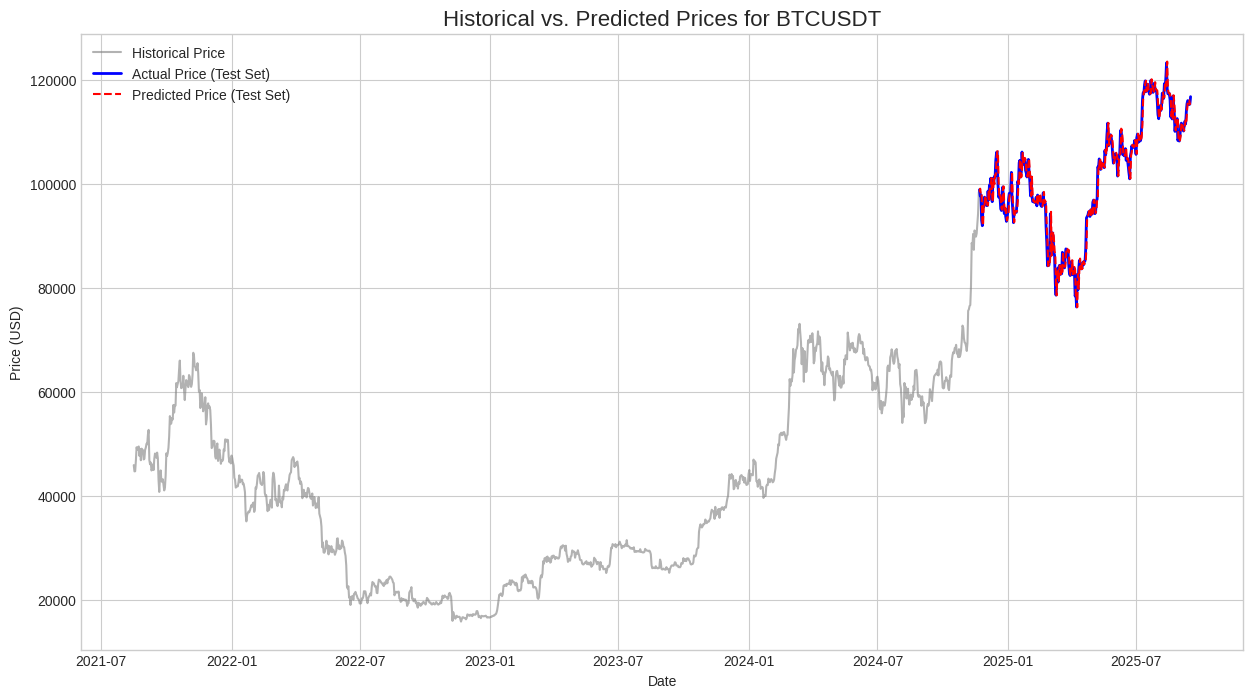


--- 4. Loading Saved Model to Predict for 2025-09-19 ---
Model loaded successfully from drive.

--- Single Day Prediction ---
PREDICTED PRICE for 2025-09-19: $116,867.71


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [ ]:
if __name__ == "__main__":

    data_df = load_and_prepare_data(DATABASE_FILE_PATH, COIN_TO_PREDICT)

    if data_df is not None:
        trained_model, X_train, X_test, y_train, y_test = train_and_save_model(data_df, MODEL_SAVE_PATH)

        make_predictions_and_plot(trained_model, data_df, X_test, y_test)

        load_and_predict_future(data_df, MODEL_SAVE_PATH, '2025-09-19')